In [1]:
#IMPORT NEEDED LIBRARIES

from tensorflow.keras.datasets import cifar10
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# LOAD THE CIFAR 10 DATASET AND NORMALIZE IT

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# PREPARE VALIDATION DATA

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print('Validation set shape:',X_valid.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training set shape: (40000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)


In [3]:
class Conv2DBatchNormReLU(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(l2),
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )

    def call(self, inputs, training=False):
        x = self.conv2d(inputs)
        x = self.batch_norm(x, training=training)
        return tf.nn.relu(x)


class ResNet9Block(tf.keras.layers.Layer):
    def __init__(self, filters, l2=1e-4, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.conv_bn_relu_1 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.conv_bn_relu_2 = Conv2DBatchNormReLU(filters=filters, l2=l2, kernel_size=kernel_size)
        self.downsample = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=1,
            strides=2,
            padding='SAME',
            use_bias=False,
            kernel_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.batch_norm = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9,
            beta_regularizer=tf.keras.regularizers.l2(l2),
            gamma_regularizer=tf.keras.regularizers.l2(l2)
        )
        self.max_pool2d = tf.keras.layers.MaxPool2D(pool_size=2)

    def call(self, inputs, training=False):
        shortcut = self.downsample(inputs)
        shortcut = self.batch_norm(shortcut, training=training)

        x = self.conv_bn_relu_1(inputs, training=training)
        x = self.max_pool2d(x)
        x = self.conv_bn_relu_2(x, training=training)

        return tf.nn.relu(x + shortcut)


def ResNet9(input_shape=(32, 32, 3), num_classes=10, l2=1e-4):
    filters_1 = 128
    filters_2 = 64
    filters_3 = 448
    filters_4 = 448

    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2DBatchNormReLU(filters_1, l2=l2)(inputs)
    x = ResNet9Block(filters_2, l2=l2)(x)

    x = Conv2DBatchNormReLU(filters_3, l2=l2)(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = ResNet9Block(filters_4, l2=l2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(l2),
        kernel_initializer=tf.keras.initializers.HeUniform(),
    )(x)

    return tf.keras.Model(inputs, x, name="ResNet9")


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [5]:
# BUILD THE MODEL

model = ResNet9(input_shape=(32, 32, 3), num_classes=10, l2=1e-4)
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('TunedC3D2model3_withauglr.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


Model: "ResNet9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_batch_norm_re_lu              │ (None, 32, 32, 128)         │           3,968 │
│ (Conv2DBatchNormReLU)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net9_block (ResNet9Block)        │ (None, 16, 16, 64)          │         119,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_batch_norm_re_lu_3            │ (None, 16, 16, 448)         │         259,840 │
│ (Conv2DBatchNormReLU)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 448)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net9_block_1 (ResNet9Block)      │ (None, 4, 4, 448)           │       3,818,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 448)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           4,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,206,592 (16.05 MB)

 Trainable params: 4,202,368 (16.03 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [6]:
# COMPILE THE MODEL AND RUN IT.

model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_valid, y_valid),
    epochs=200,
    callbacks=[early_stopping,reduce_lr,model_checkpoint])

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 64ms/step - accuracy: 0.4355 - loss: 2.1520 - val_accuracy: 0.5992 - val_loss: 1.6803 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.6453 - loss: 1.5028 - val_accuracy: 0.6407 - val_loss: 1.5184 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.7053 - loss: 1.2917 - val_accuracy: 0.7044 - val_loss: 1.2940 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.7383 - loss: 1.1758 - val_accuracy: 0.7248 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - accuracy: 0.7605 - loss: 1.0975 - val_accuracy: 0.6255 - val_loss: 1.5537 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7811 - loss: 1.0336 - val_accuracy: 0.7593 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.7937 - loss: 

<Axes: >

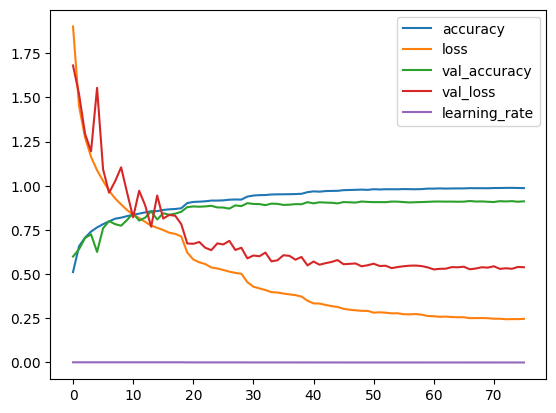

In [7]:
pd.DataFrame(history.history).plot()

In [9]:
# TESTING THE MODEL WITH TEST DATA AND PREPARE CLASSIFICATION REPORT (PRECISION , RECALL, F1-SCORE)

scores = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
target = [class_names[i].format(i) for i in range(10)]

print("\n\nTesting Accuracy :",scores[1],"\n")
print(classification_report(y_test.flatten(), np.argmax(y_pred, axis=1), target_names=target))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9006 - loss: 0.5606
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


Testing Accuracy : 0.9047999978065491 

              precision    recall  f1-score   support

    airplane       0.89      0.92      0.90      1000
  automobile       0.92      0.97      0.94      1000
        bird       0.87      0.87      0.87      1000
         cat       0.87      0.78      0.82      1000
        deer       0.92      0.90      0.91      1000
         dog       0.89      0.83      0.86      1000
        frog       0.89      0.96      0.92      1000
       horse       0.93      0.94      0.94      1000
        ship       0.96      0.93      0.94      1000
       truck       0.91      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

